# Training a Discriminative Model using PyTorch

![](https://sisec18.unmix.app/static/img/hero_header.4f28952.svg)

In this notebook, we are going to setup a baseline separation system with DNN.

### Colab Requirements

Please use the conda environment or the Pipefile if you want to run this notebook outside of colab in your local environment.


In [ ]:
%%capture
!apt install -y libsndfile1 ffmpeg
!pip install musdb
!pip install tqdm
!pip install norbert

In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [ ]:
!git clone https://github.com/sigsep/open-unmix-pytorch.git
%cd open-unmix-pytorch/

Cloning into 'open-unmix-pytorch'...
remote: Enumerating objects: 1394, done.
remote: Counting objects: 100% (1394/1394), done.
remote: Compressing objects: 100% (547/547), done.
remote: Total 1394 (delta 906), reused 1311 (delta 838), pack-reused 0
Receiving objects: 100% (1394/1394), 250.85 KiB | 679.00 KiB/s, done.
Resolving deltas: 100% (906/906), done.
/content/open-unmix-pytorch


### Generic Imports

In [ ]:
import scipy.signal
from IPython.display import Audio, display
import numpy as np
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
import random
import sklearn.preprocessing
import norbert
import musdb
warnings.simplefilter(action='ignore', category=FutureWarning)

### Setup Vocal Separation Scenario

### Load a single track and convert to spectrogram

<img src="https://sigsep.github.io/eusipco2019_tutorial/assets/twosw.gif" width="450">

In [ ]:
import torch.utils
import torch
import torch.utils.data

class SimpleMUSDBDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        subset='train',
        split='train',
        target='vocals',
        seq_duration=None,
    ):
        """MUSDB18 Dataset wrapper
        """
        self.seq_duration = seq_duration
        self.target = target
        self.mus = musdb.DB(
            download=True,
            split=split,
            subsets=subset,
        )

    def __getitem__(self, index):
        track = self.mus[index]
        track.chunk_start = random.uniform(0, track.duration - self.seq_duration)
        track.chunk_duration = self.seq_duration
        x = track.audio.T
        y = track.targets[self.target].audio.T
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


    def __len__(self):
        return len(self.mus)

Initialize the dataset

In [ ]:
train_dataset = SimpleMUSDBDataset(seq_duration=5.0)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
print(len(train_dataset))

Done!
80


Extract a single example

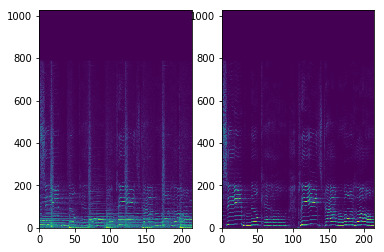

In [ ]:
import model
import torch.nn as nn

# create a spectrogram layer
stft = model.STFT(n_fft=2048, n_hop=1024)
spec = model.Spectrogram(mono=True)
transform = nn.Sequential(stft, spec)

x, y = train_dataset[7]

# transform the time domain input to spectrograms
X = transform(x[None])
Y = transform(y[None])

f, axes = plt.subplots(1, 2)
axes[0].pcolormesh(np.log(X[:, 0, 0, :].detach().numpy().T + 1))
axes[1].pcolormesh(np.log(Y[:, 0, 0, :].detach().numpy().T + 1))

display(Audio(x, rate=44100))
display(Audio(y, rate=44100))

## Compute global mean and scale of Dataset

Sample from the dataset and update mean standard deviation using scikit-learn `StandardScaler`.

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()

for x, y in tqdm_notebook(train_dataset):
    X = transform(x[None])
    scaler.partial_fit(X.squeeze().numpy())

# set inital input scaler values
scale = np.maximum(
    scaler.scale_,
    1e-4*np.max(scaler.scale_)
)
mean = scaler.mean_

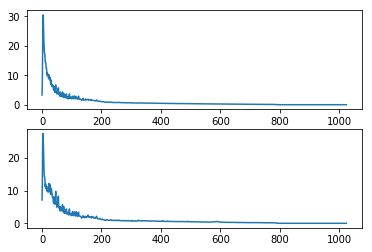

In [ ]:
f, axes = plt.subplots(2, 1)
axes[0].plot(mean)
axes[1].plot(scale)


## Set up the model

In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
import torch.optim as optim

unmix = model.OpenUnmix(
    input_mean=mean,
    input_scale=scale,
    nb_channels=1,
    hidden_size=256,
    n_fft=2048,
    n_hop=1024,
    max_bin=64,
    sample_rate=44100
).to(device)
    
optimizer = optim.RMSprop(unmix.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Train a vocal model 

In [ ]:
import utils
losses = utils.AverageMeter()
unmix.train()

for i in tqdm_notebook(range(50)):
    for x, y in tqdm_notebook(train_sampler):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        Y_hat = unmix(x)
        Y = unmix.transform(y)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        loss.backward()
        optimizer.step()
        losses.update(loss.item(), Y.size(1))
    print(losses.avg)

4.6876561641693115


4.361033284664154


4.09832276503245


3.870033913850784


3.6770143246650697


3.516858979066213


3.3734423892838614


3.2486316099762917


3.1361724972724914


3.037181226015091


2.9461529872634196


2.8612870434919992


2.78366147004641


2.710556694439479


2.6418349130948386


2.5826980747282504


KeyboardInterrupt: ignored

## Synthesize



In [ ]:
import musdb
mus = musdb.DB(download=True, subsets='test')
track = mus[1]

In [ ]:
def istft(X, rate=44100, n_fft=4096, n_hopsize=1024):
    t, audio = scipy.signal.istft(
        X / (n_fft / 2),
        rate,
        nperseg=n_fft,
        noverlap=n_fft - n_hopsize,
        boundary=True
    )
    return audio

In [ ]:
unmix.stft.center = True
unmix.eval()

audio_torch = torch.tensor(track.audio.T[None, ...]).float().to(device)

Vj = unmix(audio_torch).cpu().detach().numpy()

# compute STFT
X = unmix.stft(audio_torch).detach().cpu().numpy()
# convert to complex numpy
X = X[..., 0] + X[..., 1]*1j
X = X[0].transpose(2, 1, 0)

V = Vj[:, 0, ...].transpose(0, 2, 1)[..., None]
V = norbert.residual_model(V, X)
Y = norbert.wiener(V, X.astype(np.complex128), iterations=2)
estimates = {}
for j, name in enumerate(['vocals', 'accompaniment']):
    audio_hat = istft(
        Y[..., j].T,
        n_fft=unmix.stft.n_fft,
        n_hopsize=unmix.stft.n_hop
    )
    estimates[name] = audio_hat.T

In [ ]:
for target, estimate in estimates.items():
    print(target)
    display(Audio(estimate.T, rate=track.rate))

vocals


accompaniment
